## Analyze A/B Test Results

You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).  **Please save regularly.**

This project will assure you have mastered the subjects covered in the statistics lessons.  The hope is to have this project be as comprehensive of these topics as possible.  Good luck!

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [6]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [7]:
df = pd.read_csv('ab_data.csv')

b. Use the cell below to find the number of rows in the dataset.

In [8]:
df.shape

(294478, 5)

c. The number of unique users in the dataset.

In [9]:
df.user_id.nunique()

290584

d. The proportion of users converted.

In [10]:
df[df.converted == 1].shape[0] / df.shape[0]

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't match.

In [11]:
df.head()
df.groupby(['group', 'landing_page']).user_id.count().reset_index()
#1928 + 1965

,group,landing_page,user_id
0,control,new_page,1928
1,control,old_page,145274
2,treatment,new_page,145311
3,treatment,old_page,1965


f. Do any of the rows have missing values?

In [12]:
df.isna().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to figure out how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [13]:
df2 = df[((df.group == 'treatment') & (df.landing_page == 'new_page')) | ((df.group == 'control') & (df.landing_page == 'old_page'))]


In [14]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [15]:
df2.head()
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [16]:
df2.user_id.value_counts().reset_index().head(5)

,index,user_id
0,773192,2
1,630732,1
2,811737,1
3,797392,1
4,795345,1


c. What is the row information for the repeat **user_id**? 

In [17]:
df2[df.user_id == 773192]

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [18]:
#df2.drop(df.index[1899])

`4.` Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [19]:
df2[df2.converted == 1].shape[0] / df2.shape[0]

0.11959667567149027

b. Given that an individual was in the `control` group, what is the probability they converted?

In [20]:
df2_groupby = df2.groupby(['group', 'converted']).user_id.count().reset_index()
df2_groupby

,group,converted,user_id
0,control,0,127785
1,control,1,17489
2,treatment,0,128047
3,treatment,1,17264


In [21]:
#probability of converting within control group is 0.1204
control_cvr =  17489 / (17489 + 127785)
control_cvr

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [22]:
#probaility of converting within treatment group is 0.1188
treatment_cvr = 17264 / (17264 + 128046)
treatment_cvr

0.11880806551510564

d. What is the probability that an individual received the new page?

In [23]:
df2.head()
df2[df2.landing_page == 'new_page'].shape[0] / df2.shape[0]

0.5000636646764286

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

**Your answer goes here.**

The test looks like it was run fairly as evidenced by the fact that almost 50% of individuals recieved the new page from analysing the data from the df2 dataframe.

The conversion rate was slightly smaller for the treatment group versus the conntrol group. From looking at the evidence we cannot conclude that the trea

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**Put your answer here.**

Null Hypothesis: **$p_{new}$** =< **$p_{old}$** 

Alternative Hypothesis: **$p_{new}$** > **$p_{old}$** 

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [24]:
p_old = df2[df2.converted == 1].shape[0] / df2.shape[0]
p_old

0.11959667567149027

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [25]:
p_new = df2[df2.converted == 1].shape[0] / df2.shape[0]
p_new

0.11959667567149027

c. What is $n_{new}$, the number of individuals in the treatment group?

In [26]:
n_new = df2[df2.group == 'treatment']
n_new.shape[0]

145311

d. What is $n_{old}$, the number of individuals in the control group?

In [27]:
n_old = df2[df2.group == 'control']
n_old.shape[0]

145274

In [28]:
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [29]:
new_page_converted = np.random.binomial(1, p_new, n_new.shape[0])

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [30]:
old_page_converted = np.random.binomial(1, p_old, n_old.shape[0])

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [31]:
diff = np.mean(new_page_converted) - np.mean(old_page_converted)
diff

-0.00034017463490855493

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [32]:
p_diffs = []

for i in range(10000):
    new_page = np.random.binomial(1, p_new, n_new.shape[0])
    old_page = np.random.binomial(1, p_old, n_old.shape[0])
    difference = np.mean(new_page) - np.mean(old_page)
    p_diffs.append(difference)

In [33]:
obs_diffs = treatment_cvr - control_cvr
np.mean(p_diffs), obs_diffs

(3.6632884325919114e-06, -0.0015782389853555567)

In [34]:
#Let's add confidence intervals with 95%
lower, upper = np.percentile(p_diffs, 2.5), np.percentile(p_diffs, 97.5)
lower, upper

(-0.0023159027148574561, 0.0023513634613699574)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

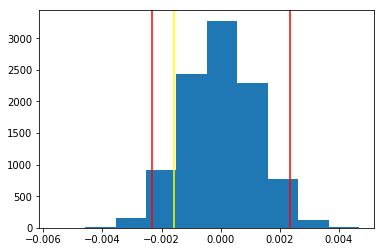

In [35]:
p_diffs = np.array(p_diffs)
plt.axvline(lower, color = 'red')
plt.axvline(upper, color = 'red')
plt.axvline(obs_diffs, color = 'yellow')
plt.hist(p_diffs);

We can see from looking at the distribution using a 95% confidence interval that most data points fall within this region. Our observed stat falls within this region, suggesting that the null hypothesis did generate our statistic.

As per the Central Limit Theorem the sample mean follows a normal distribution

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [36]:
#We want to center the distribution on the null hypothesis which is 0.
p_val = (p_diffs > obs_diffs).mean()
p_val

0.90410000000000001

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

We are looking to understand whether the new page is better at converting than the old page and whether the following results observed from our data is statistically significant: 

 - **-0.0015782389853555567**
 
Our hypothesis were set to the following:

Null Hypothesis: **$p_{new}$** =< **$p_{old}$** 
Alternative Hypothesis: **$p_{new}$** > **$p_{old}$** 

From looking at the historgram distribution for our simulation. We can see that more than half of the distribution points are greater than the observed statistic. This can be qualtified by having obtained the following p-value:

**0.90510000000000002**

Given that the p value is greater than the type 1 error rate threshold of 5%. We do not have statistically signficant results to suggest that the new page is better at converting versus the old page.

Therefore we fail to reject the null hypothesis!





l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [37]:
import statsmodels.api as sm

#The relevant figures are already stored within variables below

convert_old = df2[df2.group == 'control'].converted.sum()
convert_new = df2[df2.group == 'treatment'].converted.sum()
n_old_sample = df2[df2.group == 'control'].shape[0]
n_new_sample = df2[df2.group == 'treatment'].shape[0]

convert_old, convert_new, n_old_sample, n_new_sample

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


(17489, 17264, 145274, 145311)

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [38]:
from statsmodels.stats.proportion import proportions_ztest
stat, pval = proportions_ztest([convert_old, convert_new], [n_old_sample, n_new_sample], value=None, alternative='smaller', prop_var=False)
stat, pval

(1.3116075339133115, 0.90517370514059103)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**Put your answer here.**

The p value again comes above the type 1 error threshold rate indicating that the observed statistic is not statistically signficant. Which therefore enables us to fail to reject the hypothesis.

The Z score tells us how many standard deviations a data point is from the mean. A larger Z score value indicates that the result was unlikely due to chance.



<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

In this case we would be using a logistic regression as the result can only be binary i.e. conversion or no conversion.

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [39]:
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [40]:
df2['intercept'] = 1
df2[['control', 'treatment']] = pd.get_dummies(df2.group)
df2.drop(columns = 'control', inplace = True)
df2.rename(columns = {'treatment': 'ab_page'}, inplace = True)
df2.head()


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]
/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#i

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [41]:
import statsmodels.api as sm
from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)
logit_mod = sm.Logit(df2.converted, df2[['intercept', 'ab_page']])
results = logit_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [42]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290585
Model:                          Logit   Df Residuals:                   290583
Method:                           MLE   Df Model:                            1
Date:                Tue, 28 Jul 2020   Pseudo R-squ.:               8.085e-06
Time:                        11:46:00   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1897
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.312      0.190      -0.037       0.007
==============================================================================
"""

In [43]:
np.exp(-0.150), 1 / np.exp(-0.150)

(0.86070797642505781, 1.1618342427282831)

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**?

From the regression model, we can interpret the new page to be 1.16x less likely to convert a user holding all other variables constant.

We can see that the p value is 0.190, which is greater than the type 1 error threshold, indicating that that the relationship between the ab_page and the dependent variable (converted) is not statistically significant.

For the regression model the null and alternative hypothesis is as follows:

Null Hypothesis: **$p_{new}$** = **$p_{old}$** 

Alternative Hypothesis: **$p_{new}$** != **$p_{old}$** 

This is different from part 2 where we are testing whether the new page is better than the old page. Whilst the regression model is testing to see if there is a difference between the new page and old page. So consequently the p values represent different things for: 

- part 2
- The regression model.

This is the reason why we see different p values.

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**Put your answer here.**

When conducting A/B tests we need to be mindful of the factors that may contribute to bias results such as the following:

**Change Aversion** - Existing users may give an unfair advantage to the old version, simply because they're unhappy with change, even if its better.

**Novelty Effect** - Exisiting users may give an unfair advantage to the new version, because they're excited or drawn to the change, even if it isn't any better in the long run.

They're may also be other factors such as weekday vs weekend performance which is something we may want to incorporate into our regression model. Though as we add more additional terms we need to be mindful of multicolinearity as we want predictor variables to be as independent as possible.


g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [71]:
df_country = pd.read_csv('countries.csv')
df_country.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [72]:
df_2_country = pd.merge(df2, df_country)
df_2_country[['CA', 'UK', 'US']] = pd.get_dummies(df_2_country.country)
df_2_country.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,CA,UK,US
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US,0,0,1


In [73]:
#Build a logisitic regression using US as a baseline
logit_2 = sm.Logit(df_2_country.converted, df_2_country[['intercept', 'ab_page', 'CA', 'UK']])
results = logit_2.fit()

Optimization terminated successfully.
         Current function value: 0.366112
         Iterations 6


In [74]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290585
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            3
Date:                Tue, 28 Jul 2020   Pseudo R-squ.:               2.324e-05
Time:                        12:07:43   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1758
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9893      0.009   -223.763      0.000      -2.007      -1.972
ab_page       -0.0150      0.011     -1.308      0.191      -0.037       0.007
CA            -0.0408      0.027     -1.516      0.130      -0.093       0.012
UK             0.0099      0.013      0.744      0.457      -0.016       0.036
==============================================================================
"""

In [48]:
1/np.exp(-0.0408), np.exp(0.0099)

(1.0416437559600236, 1.0099491671175422)

From looking at the results we can see that the p values are greater than the type 1 error rate, indicating that there isn't a statistically significant relationship between the independent variables and the response variable (conversion).

From interpreting the coefficients we can see that a user in Canada is 1.04 times less likely to convert vs a user in US. Whereas a person in the UK is 1.01 times more likely to convert that a user in the US. These differences aren't practically signficant.

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [75]:
df_2_country['US_conversion'] = df_2_country.ab_page * df_2_country.US
df_2_country['UK_conversion'] = df_2_country.ab_page * df_2_country.UK
df_2_country['CA_conversion'] = df_2_country.ab_page * df_2_country.CA
df_2_country.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,CA,UK,US,US_conversion,UK_conversion,CA_conversion
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,0,0,1,0,0,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,0,1,0,0,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,0,1,1,0,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,0,1,1,0,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US,0,0,1,0,0,0


In [77]:
#Now we want to build a lostical regression model using 'US_conversion' as the baseline
logit_3 = sm.Logit(df_2_country.converted, df_2_country[['intercept', 'CA_conversion', 'UK_conversion']])
results = logit_3.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366112
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290585
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            2
Date:                Tue, 28 Jul 2020   Pseudo R-squ.:               2.364e-05
Time:                        12:10:50   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                   0.08085
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
intercept        -1.9963      0.006   -322.050      0.000      -2.008      -1.984
CA_conversion    -0.0752      0.038     -1.997      0.046      -0.149      -0.001
UK_conversion     0.0149      0.017      0.862      0.389      -0.019       0.049
=================================================================================
"""

In [78]:
1/np.exp(-0.0752), np.exp(0.0149)

(1.0780997492739288, 1.0150115583846535)

From looking at the above we can interpret the results in the following way:

- A user who gets the treatment page from Canada is 1.08x less likely to convert compared to a user who gets the treatment page from the US holding all other variables constant. Whilst we can say this relationship is statistically significant given that the p value is 0.046. We wouldn't say this is practically significant.
- A user who gets the treatment page from UK is 1.02x more likely to convert compared to a user who gets the treatment page from the US holding all other variables constant. From looking at the p value we can't say that this relationship is statistically significant.

<a id='conclusions'></a>
## Finishing Up

> Congratulations!  You have reached the end of the A/B Test Results project!  You should be very proud of all you have accomplished!

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the rubric (found on the project submission page at the end of the lesson). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations!

In [79]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0